# LSTM on Tully's system

#### Python Coding TangDD 4/10/2021
#### C Coding JiaLY 3/1/2021

### Libraries

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from numpy import random

2022-06-14 18:12:03.164220: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /public1/home/sc60217/boxhan/g09/g09/bsd:/public1/home/sc60217/boxhan/g09/g09/local:/public1/home/sc60217/boxhan/g09/g09/extras:/public1/home/sc60217/boxhan/g09/g09:/public1/soft/gcc/10.2.0/lib64:/public1/soft/hdf5/1.10.4-cxx/lib:/public1/soft/openmpi/3.1.6-intel/lib:/public1/soft/intel/2017/debugger_2017/libipt/intel64/lib:/public1/soft/intel/2017/debugger_2017/iga/lib:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/daal/../tbb/lib/intel64_lin/gcc4.4:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/daal/lib/intel64_lin:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/tbb/lib/intel64/gcc4.7:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/mkl/lib/intel64_lin:/public1/soft/in

In [2]:
import matplotlib.pyplot as plt

### Read Data and Generate Dataset

#### FORMAT OF DATASET

       0 1 2  3  4      5      6      7      8        9        10
NTRAJ,[X,V,E0.E1.RERHO0,RERHO1,IMRHO1,ACTIVE,SPECIAL1,SPECIAL2,SPECIAL3]

In [3]:
# This is a 1 a.u. timestep.
f=open("../reference_50_g2e2_tail_clean/tail_firstpart_full/result_traj_2.txt",'r')
rawdata=f.readlines()
f.close()

nvel=0
ntraj=0

for i in range(0,len(rawdata)):
    dataline=rawdata[i].split()
    if (len(dataline)>0):
        if (dataline[0]=='VELOC'):
            nvel+=1
        if (dataline[0]=='TRAJ'):
            ntraj+=1 

nele=len(rawdata[-1].split())

In [4]:
print("nvel=",nvel,"ntraj=",ntraj,"nele=",nele)

nvel= 30 ntraj= 1500 nele= 11


In [5]:
all_data_x=[]
all_data_y=[]
elec_value=[]
itraj=-1
for i in range(0,len(rawdata)):
    dataline=rawdata[i].split()
    if (len(dataline)>0):
        if (dataline[0]=='TRAJ'):
            itraj+=1
            all_data_x.append([])
            all_data_y.append([])
    if (len(dataline)>2):
        ele_train=[0,1,2,3,4,5,6,8,9]
        ele_test =[4,5,6]
        #for j in range(nele):
        temp_list=[]
        for j in ele_train:
            temp_list.append(float(dataline[j]))
        all_data_x[itraj].append(temp_list)
        temp_list=[]
        for j in ele_test:
            temp_list.append(float(dataline[j]))
        all_data_y[itraj].append(temp_list)
        elec_value.append(float(dataline[4]))

In [6]:
del rawdata

In [7]:
#elec_value_numpy=np.array(elec_value)
#del elec_value
#elec_max = elec_value_numpy.max()
#elec_min = elec_value_numpy.min()
#elec_avg = np.mean(elec_value_numpy)
#del elec_value_numpy
#print(elec_max,elec_min,elec_avg)

In [8]:
for i in range(itraj):
    print(len(all_data_x[i]),len(all_data_y[i]))

219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
0 0
219 219
219 219
219 219
0 0
219 219
219 219
0 0
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
219 219
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
0 0
218 218
218 218
218 218
0 0
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
0 0
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
218 218
217 217
217 217
217 217
0 0
217 217
217 217
217 217
217 217
217 217
217 217
217 217
0 0
217 217
217 217
217 217
217 217
217 217
217 217
217 217
217 217
217 217
217 217
217 217
217 217
217 217
217 217
217 217
0 0
217 217
217 

#### Get a 100-length subset for all trajectories

A minor concern: initial velocity results in different length of trajs.

input_length is the input timelength.

In [9]:
input_length = 50
predict_length = 1

In [10]:
# This is batched data.
all_data_packed_x=[]
all_data_packed_y=[]

# From each trajectory...
for i in range(ntraj):
    #print(int(400./int(i/nvel+4.)))
    #for j in range(0,len(all_data_x[i])-input_length-predict_length,int(400./int(float(i)/float(nvel)+4.0))):
    #    all_data_packed_x.append(all_data_x[i][j:j+input_length])
    #    all_data_packed_y.append(all_data_y[i][j+input_length+predict_length-1])
    for j in range(0,len(all_data_x[i])-input_length-predict_length):
        #"""
        if (j%3==0):
            all_data_packed_x.append(all_data_x[i][j:j+input_length])
            all_data_packed_y.append(all_data_y[i][j+input_length+predict_length-1])
        """
        if (i<300):
            if (j%20==0):
                all_data_packed_x.append(all_data_x[i][j:j+input_length])
                all_data_packed_y.append(all_data_y[i][j+input_length+predict_length-1])
        else:
            if (j%10==0):
                all_data_packed_x.append(all_data_x[i][j:j+input_length])
                all_data_packed_y.append(all_data_y[i][j+input_length+predict_length-1])
        """
        #start_pop=all_data_x[i][j][4]
        #end_pop  =all_data_x[i][j+input_length-1][4]
        #pop_change = np.abs(end_pop-start_pop)
        #pop_change_list.append(pop_change)
        #if (j%10==0 or pop_change>0.02):
            #all_data_packed_x.append(all_data_x[i][j:j+input_length])
            #all_data_packed_y.append(all_data_y[i][j+input_length:j+input_length+predict_length])
            #all_data_packed_y.append(all_data_y[i][j+input_length+predict_length])


In [11]:
del all_data_x
del all_data_y

In [12]:
nsamp=len(all_data_packed_x)

In [13]:
len(all_data_packed_x[33])

50

In [14]:
all_data_packed_x[9999]

[[1.691506823,
  0.013777898,
  -0.178181292,
  0.178181292,
  0.765677898,
  -0.359385773,
  0.223523983,
  -0.000561138,
  0.000561138],
 [1.70528963,
  0.013787656,
  -0.178450282,
  0.178450282,
  0.765679854,
  -0.414842983,
  0.083787126,
  -0.000552937,
  0.000552937],
 [1.719082135,
  0.013797294,
  -0.178716142,
  0.178716142,
  0.765681927,
  -0.41791711,
  -0.06673862,
  -0.000544868,
  0.000544868],
 [1.732884218,
  0.013806813,
  -0.178978903,
  0.178978903,
  0.765683856,
  -0.367993404,
  -0.209005769,
  -0.000536928,
  0.000536928],
 [1.746695761,
  0.013816215,
  -0.179238597,
  0.179238597,
  0.765685402,
  -0.271198258,
  -0.324881554,
  -0.000529115,
  0.000529115],
 [1.760516647,
  0.0138255,
  -0.179495256,
  0.179495256,
  0.765686382,
  -0.139683905,
  -0.399473584,
  -0.000521427,
  0.000521427],
 [1.774346761,
  0.01383467,
  -0.179748909,
  0.179748909,
  0.765686688,
  0.009868916,
  -0.423069586,
  -0.000513861,
  0.000513861],
 [1.788185988,
  0.013843727,

In [15]:
all_data_packed_y[9999]

[0.765678876, -0.224893903, 0.35810458]

In [16]:
all_data_packed_x[10000]

[[1.732884218,
  0.013806813,
  -0.178978903,
  0.178978903,
  0.765683856,
  -0.367993404,
  -0.209005769,
  -0.000536928,
  0.000536928],
 [1.746695761,
  0.013816215,
  -0.179238597,
  0.179238597,
  0.765685402,
  -0.271198258,
  -0.324881554,
  -0.000529115,
  0.000529115],
 [1.760516647,
  0.0138255,
  -0.179495256,
  0.179495256,
  0.765686382,
  -0.139683905,
  -0.399473584,
  -0.000521427,
  0.000521427],
 [1.774346761,
  0.01383467,
  -0.179748909,
  0.179748909,
  0.765686688,
  0.009868916,
  -0.423069586,
  -0.000513861,
  0.000513861],
 [1.788185988,
  0.013843727,
  -0.179999589,
  0.179999589,
  0.7656863,
  0.1583496,
  -0.392435387,
  -0.000506415,
  0.000506415],
 [1.802034215,
  0.013852672,
  -0.180247327,
  0.180247327,
  0.765685285,
  0.286655769,
  -0.311293664,
  -0.000499087,
  0.000499087],
 [1.815891332,
  0.013861506,
  -0.180492152,
  0.180492152,
  0.765683791,
  0.378160235,
  -0.189909111,
  -0.000491875,
  0.000491875],
 [1.829757228,
  0.013870231,
 

#### FORMAT OF DATASET

NTRAJ,[X,V,E0.E1.RERHO0,RERHO1,IMRHO1,ACTIVE,POSS]

Say, we are planning to feed X(t),V(t),E0(t),E1(t),RHO0(t),ACT(t) into the network, and get RHO0(t+50),ACT(t+50).

In [ ]:
dataset_x=np.array(all_data_packed_x)
dataset_y=np.array(all_data_packed_y)

In [ ]:
del all_data_packed_x
del all_data_packed_y

In [ ]:
dataset_x.shape

In [20]:
dataset_y.shape

(175480, 3)

#### Normalize

       0 1       2      3      4             5        6
       0 1 2  3  4      5      6      7      8        9        10
NTRAJ,[X,V,E0.E1.RERHO0,RERHO1,IMRHO1,ACTIVE,SPECIAL1,SPECIAL2,SPECIAL3]

In [21]:
for i in range(nsamp):
    for j in range(input_length):
        dataset_x[i][j][0]=dataset_x[i][j][0]/20.0
        dataset_x[i][j][1]=(dataset_x[i][j][1]*2000-17.0)/30.0
        #dataset_x[i][j][2]=dataset_x[i][j][2]*5.0
        #dataset_x[i][j][3]=dataset_x[i][j][3]*5.0
        #dataset_x[i][j][1]=(dataset_x[i][j][1]*2000-17.0)/30.0
        dataset_x[i][j][2]=dataset_x[i][j][2]*2.5
        dataset_x[i][j][3]=dataset_x[i][j][3]*2.5
        dataset_x[i][j][4]=dataset_x[i][j][4]-0.5
        dataset_x[i][j][5]=dataset_x[i][j][5]
        dataset_x[i][j][6]=dataset_x[i][j][6]
        #dataset_x[i][j][5]=dataset_x[i][j][5]*1.25
        #dataset_x[i][j][6]=dataset_x[i][j][6]*0.25
        #aaa=dataset_x[i][j][4]-0.5
        #dataset_x[i][j][4]=4*aaa*aaa*aaa+0.5*aaa
        #dataset_x[i][j][4]=(dataset_x[i][j][4]-elec_avg)/(elec_max-elec_min)
        #dataset_x[i][j][5]=dataset_x[i][j][5]
        #dataset_x[i][j][6]=dataset_x[i][j][6]
    
for i in range(nsamp):
    dataset_y[i][0]=dataset_y[i][0]-0.5
    #aaa=dataset_y[i][0]-0.5
    #dataset_y[i][0]=4*aaa*aaa*aaa+0.5*aaa
    #dataset_y[i][0]=(dataset_y[i][0]-elec_avg)/(elec_max-elec_min)
    dataset_y[i][1]=dataset_y[i][1]
    dataset_y[i][2]=dataset_y[i][2]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.2, random_state=42)

## Build Model

In [23]:
model = Sequential()
model.add(LSTM(72, activation='tanh', input_shape=(dataset_x.shape[1], dataset_x.shape[2]), return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(72, activation='tanh', return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(72, activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(3, activation='tanh'))
model.compile(optimizer='adam', loss='mse')

2022-06-14 18:15:16.750417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /public1/home/sc60217/boxhan/g09/g09/bsd:/public1/home/sc60217/boxhan/g09/g09/local:/public1/home/sc60217/boxhan/g09/g09/extras:/public1/home/sc60217/boxhan/g09/g09:/public1/soft/gcc/10.2.0/lib64:/public1/soft/hdf5/1.10.4-cxx/lib:/public1/soft/openmpi/3.1.6-intel/lib:/public1/soft/intel/2017/debugger_2017/libipt/intel64/lib:/public1/soft/intel/2017/debugger_2017/iga/lib:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/daal/../tbb/lib/intel64_lin/gcc4.4:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/daal/lib/intel64_lin:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/tbb/lib/intel64/gcc4.7:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/mkl/lib/intel64_lin:/public1/soft/intel/2017/c

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 72)            23616     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 72)            41760     
_________________________________________________________________
lstm_2 (LSTM)                (None, 72)                41760     
_________________________________________________________________
dense (Dense)                (None, 3)                 219       
Total params: 107,355
Trainable params: 107,355
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(x_train, y_train, epochs=5, validation_split=0.2, verbose=1, batch_size=32)

2022-06-14 18:15:18.246398: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
3510/3510 [==============================] - 321s 90ms/step - loss: 9.0816e-04 - val_loss: 2.5878e-05
Epoch 2/5
3510/3510 [==============================] - 316s 90ms/step - loss: 2.7521e-05 - val_loss: 1.7111e-05
Epoch 3/5
3510/3510 [==============================] - 315s 90ms/step - loss: 1.8232e-05 - val_loss: 9.1286e-06
Epoch 4/5
3510/3510 [==============================] - 314s 89ms/step - loss: 1.2331e-05 - val_loss: 1.3602e-05
Epoch 5/5
3510/3510 [==============================] - 315s 90ms/step - loss: 1.1543e-05 - val_loss: 1.5147e-06


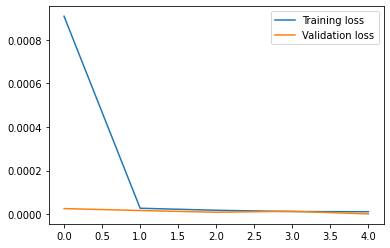

In [26]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.legend()

In [27]:
# So let's check a trajectory...
test_output = model.predict(x_test, verbose=0)

In [28]:
test_output[:,0].shape

(35096,)

In [29]:
y_test[:,0].shape

(35096,)

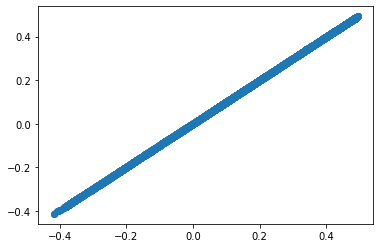

In [30]:
plt.scatter(y_test[:,0],test_output[:,0])

In [31]:
fo=open('tully_out_50_tail_try4.txt','w')
for ii in range(0,len(y_test.squeeze())):
    fo.write("{0}\t{1}\n".format(y_test[ii][0], test_output[ii][0]))
fo.close()

In [32]:
# Export the model to a SavedModel
model.save('model_tail_50_try4', save_format='tf')

2022-06-14 18:41:57.331182: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_tail_50_try4/assets


In [33]:
model.save('model_h5_tail_50_try4', save_format='h5')

In [34]:
test_output.size

105288

In [35]:
test_output[:,0]

array([-0.2737969 , -0.20434172,  0.08788192, ...,  0.19674172,
        0.09097552,  0.0771872 ], dtype=float32)

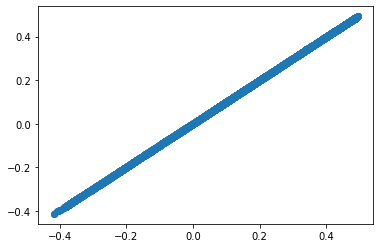

In [36]:
plt.scatter(y_test[:,0],test_output[:,0])

In [37]:
fo=open('tully_out_50_tail_full_try4.txt','w')
for ii in range(0,len(y_test.squeeze())):
    fo.write("{0}\t{1}\n".format(y_test[ii][0], test_output[ii][0]))
    fo.write("{0}\t{1}\n".format(y_test[ii][1], test_output[ii][1]))
    fo.write("{0}\t{1}\n".format(y_test[ii][2], test_output[ii][2]))
fo.close()

In [38]:
!pwd

/public1/home/sc60217/TangDD_2021/2_LSTM/999_Final/no_deco/tully_3_1/training_g2e2_di_multi_clean


In [39]:
f=open('sample.txt','r')
rawdata=f.readlines()
f.close()

fieldtest_x=np.zeros([1,50,7])

for i in range(50):
    for j in range(7):
        fieldtest_x[0][i][j]=float(rawdata[i].split()[j])

FileNotFoundError: [Errno 2] No such file or directory: 'sample.txt'

In [ ]:
"""
for i in range(1):
    for j in range(50):
        fieldtest_x[i][j][0]=fieldtest_x[i][j][0]/20.0
        fieldtest_x[i][j][1]=(fieldtest_x[i][j][1]*2000-17.0)/30.0
        fieldtest_x[i][j][2]=fieldtest_x[i][j][2]-0.5
"""

In [ ]:
fieldtest_x

In [ ]:
fieldtest_y = model.predict(fieldtest_x, verbose=0)

In [ ]:
fieldtest_y